## model loading and testing

In [2]:
import torch
import joblib
from datetime import datetime
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import yaml
import seaborn as sns
from utils import parse_pv_yml
from lume_model.utils import variables_from_yaml, variables_as_yaml
from lume_model.models import TorchModel, TorchModule

In [12]:
model_path = '/sdf/data/ad/ard/u/zihanzhu/ml/lcls_fel_tuning/model/'
# Specify the model foldel
model_version = '2024-04-08_06-02-49_nn/'

loaded_model_path = model_path + model_version + 'lcls_fel_model.pt'
loaded_input_scaler_path = model_path + model_version + 'lcls_fel_input_scaler.pt'
loaded_output_scaler_path = model_path + model_version + 'lcls_fel_output_scaler.pt'

# Load the model state dictionary
model = torch.load(loaded_model_path)

# Load the model state dictionary
input_scaler = torch.load(loaded_input_scaler_path)
output_scaler = torch.load(loaded_output_scaler_path)
# Load the input and output variables
parsed_variables = parse_pv_yml(model_path + model_version + 'feature_config.yml')
input_variables, output_variables = variables_from_yaml(model_path + model_version + 'feature_config.yml')
input_cols = parsed_variables['input_variables']
output_cols = parsed_variables['output_variables']

/lscratch/zihanzhu/tmp/ipykernel_1842493/3606344527.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(loaded_model_path)
/lscratch/zihanzhu/tmp/ipykern

In [27]:
variable_ranges = {}
for variable_name in parsed_variables['input_variables']:
    var_range = parsed_variables['input_variables'][variable_name].get('value_range')
    if var_range:
        variable_ranges[variable_name] = var_range
variable_ranges

{'SOLN:IN20:121:BACT': [0.47425007997912555, 0.47625190926236516],
 'QUAD:IN20:121:BACT': [0.004845129938410696, 0.006060606879975964],
 'QUAD:IN20:122:BACT': [-0.009722815997612296, -0.007999968661393821],
 'QUAD:IN20:361:BACT': [-3.708366255695181, -3.3010309724979545],
 'QUAD:IN20:371:BACT': [2.6267023562600937, 2.8524723067807636],
 'QUAD:IN20:425:BACT': [-2.007040779782416, -1.2312732184978312],
 'QUAD:IN20:441:BACT': [-0.0031390316106671237, 0.008926103892761628],
 'QUAD:IN20:511:BACT': [3.1371632991173994, 3.559676902924417],
 'QUAD:IN20:525:BACT': [-3.2946903918675177, -2.2590588778565155],
 'QUAD:LI21:201:BACT': [-7.1402876973476435, -6.631988617674177],
 'QUAD:LI21:211:BACT': [6.118047771463832, 6.307647237524743],
 'QUAD:LI21:221:BACT': [-0.49855585922041346, -0.23434117236280477],
 'QUAD:LI21:251:BACT': [-0.3425994485112241, -0.3034467112689866],
 'QUAD:LI21:271:BACT': [-6.14391820522867, -5.909600157524937],
 'QUAD:LI21:278:BACT': [7.913994891674892, 8.319470820407245],
 '

## Create a LUME model to wrap input, output transformers and neural network intor TorchModule

In [15]:
# create TorchModel
lume_model = TorchModel(
    model=loaded_model_path,
    input_variables=input_variables,
    output_variables=output_variables,
    input_transformers=[input_scaler],
    output_transformers=[output_scaler],
)



In [16]:
# wrap in TorchModule
lume_module = TorchModule(
    model=lume_model,
    input_order=lume_model.input_names,
    output_order=lume_model.output_names,
)

lume_module

TorchModule(
  (base_model): Sequential(
    (0): Linear(in_features=42, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
    (4): Dropout(p=0.05, inplace=False)
    (5): Linear(in_features=128, out_features=64, bias=True)
    (6): ELU(alpha=1.0)
    (7): Dropout(p=0.05, inplace=False)
    (8): Linear(in_features=64, out_features=16, bias=True)
    (9): ELU(alpha=1.0)
    (10): Dropout(p=0.05, inplace=False)
    (11): Linear(in_features=16, out_features=16, bias=True)
    (12): ELU(alpha=1.0)
    (13): Linear(in_features=16, out_features=1, bias=True)
  )
  (input_transformers_0): AffineInputTransform()
  (output_transformers_0): AffineInputTransform()
)

## Test model performance 

In [17]:
# wider beam and photon energy 
def dataset_filter(dataset):
    # Filtering based on multiple conditions
    condition = (dataset['ACCL:LI21:1:L1S_S_PV'] < 0) & (dataset['ACCL:LI21:1:L1S_S_AV'] > 100) & \
                (dataset['ACCL:LI22:1:ADES'] > 3000) &  (dataset['ACCL:LI22:1:ADES'] < 5300) & \
                (dataset['XRMS on VCC'] > 300) & (dataset['XRMS on VCC'] < 350) & \
                (dataset['YRMS on VCC'] > 300) & (dataset['YRMS on VCC'] < 350) & \
                (dataset['hxr_pulse_intensity'] > 0.02) & (dataset['hxr_pulse_intensity'] < 5) & \
               (dataset['Charge at gun [pC]'] > 240) & (dataset['Charge at gun [pC]'] < 260) & \
                (dataset['Charge after BC1 [pC]'] < 200) & \
                (dataset['HXR electron energy [GeV]'] > 8) & (dataset['HXR photon energy [eV]'] > 7000)
                # all_df['hxr_pulse_intensity'] > 0.05)
    return dataset[condition]
                # (dataset['Bunch length at BC1'] > 200) & (dataset['Bunch length at BC1'] < 300) & \
                # (dataset['Bunch length at BC2'] > 3e3) & (dataset['Bunch length at BC2'] < 1e5) & \
 

### October 2024

In [32]:
# get testing samples from dataset
data_from_archiver = pd.read_pickle('/sdf/data/ad/ard/u/zihanzhu/ml/lcls_fel_tuning/dataset/hxr_archiver_Oct2024.pkl')
data_from_archiver = dataset_filter(data_from_archiver)

filter_time_frame = 1
if filter_time_frame:
    # Convert start and end times to pandas Timestamp objects
    start_time = pd.Timestamp('2024-10-1 00:00:00').tz_localize('US/Pacific')
    end_time = pd.Timestamp('2024-10-15 00:00:00').tz_localize('US/Pacific')
    # when we will look into the specific time frame
    test_set = data_from_archiver[(data_from_archiver.index >= start_time) & (data_from_archiver.index <= end_time)]
else:
    test_set = data_from_archiver
print('test set size:',test_set.shape[0])

test set size: 566782


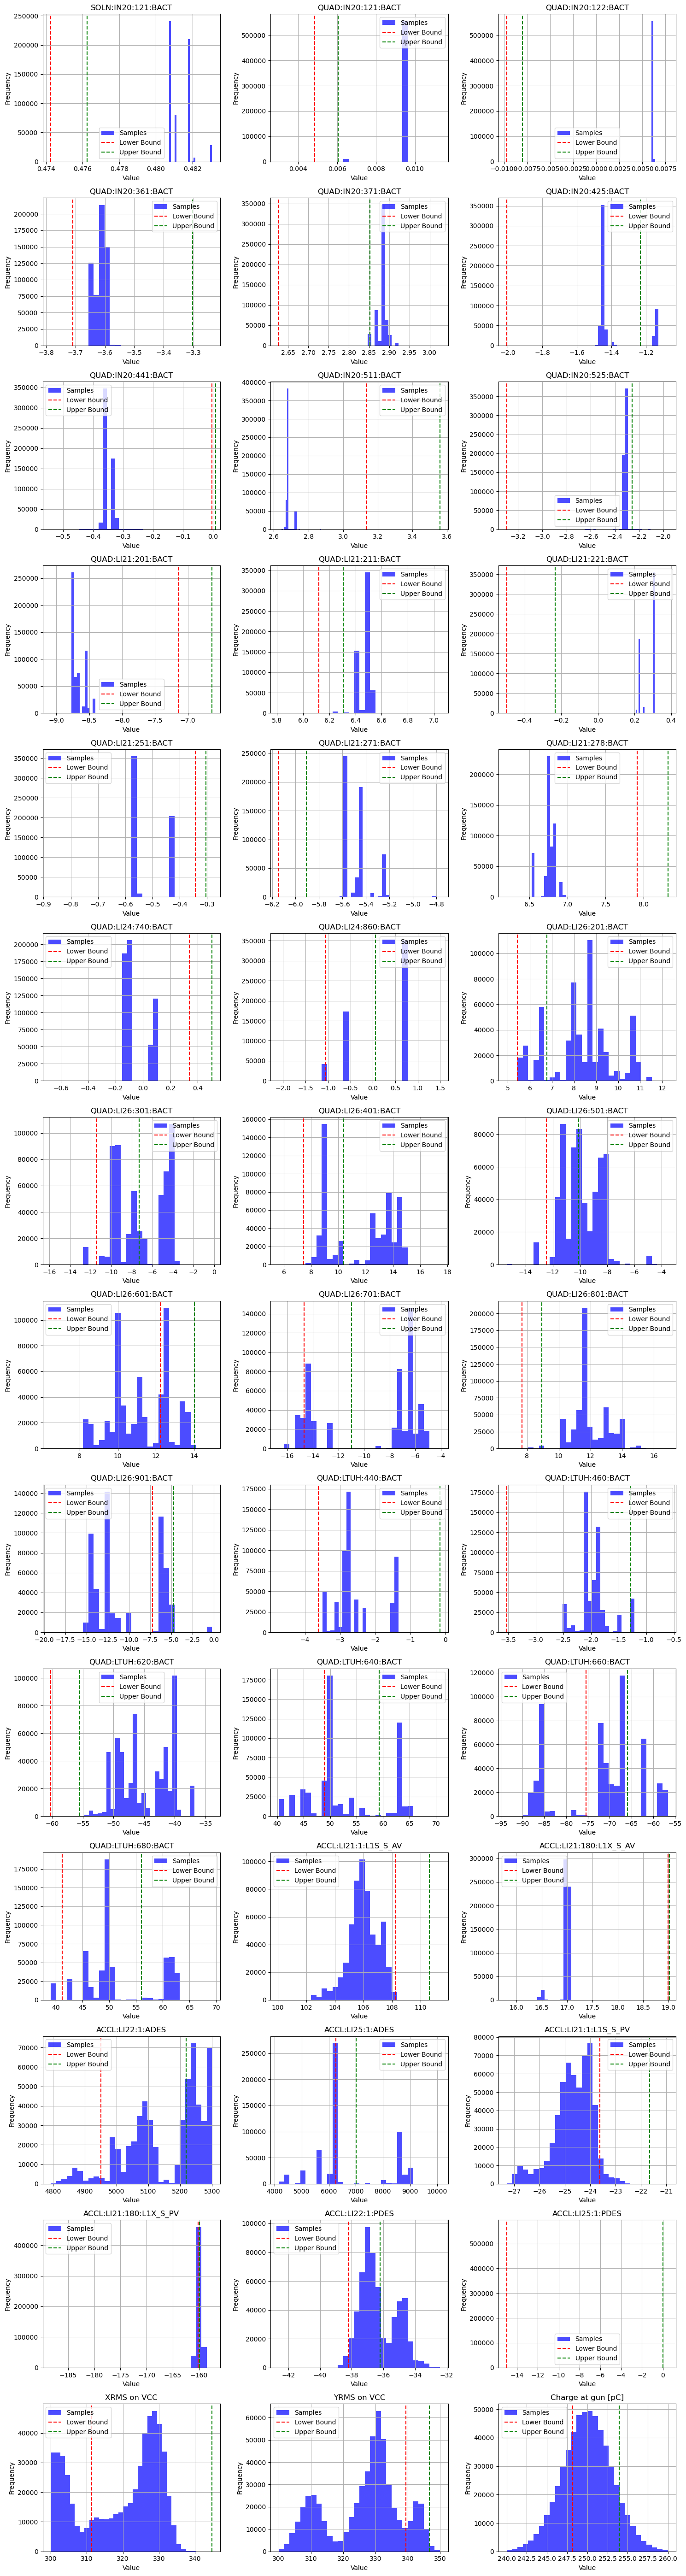

In [33]:
num_variables = len(variable_ranges)
rows = (num_variables + 2) // 3  # Set number of rows in the plot grid

fig, axes = plt.subplots(rows, 3, figsize=(15, rows * 4))
axes = axes.flatten()  # Flatten the 2D array of axes

for i, (variable_name, var_range) in enumerate(variable_ranges.items()):
    lower_bound, upper_bound = var_range
    ax = axes[i]
    
    # Plot the histogram of the variable
    test_set[variable_name].hist(bins=30, ax=ax, alpha=0.7, color='blue', label='Samples')
    
    # Plot the bounds
    ax.axvline(lower_bound, color='red', linestyle='--', label='Lower Bound')
    ax.axvline(upper_bound, color='green', linestyle='--', label='Upper Bound')
    
    # Labels and title
    ax.set_title(variable_name)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend()

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [34]:
# Define the fractions of the total number of rows for the selected validation set
selected_ranges = [(0, 1)]

selected_validation_set = pd.DataFrame()
for start_fraction, end_fraction in selected_ranges:
    start_index = int(start_fraction * len(test_set))
    end_index = int(end_fraction * len(test_set))
    subset = test_set.iloc[start_index:end_index]
    selected_validation_set = pd.concat([selected_validation_set, subset])


input_data = torch.tensor(selected_validation_set[lume_model.input_names].values)
model_output = lume_module(input_data)
ground_truth = selected_validation_set[lume_model.output_names]

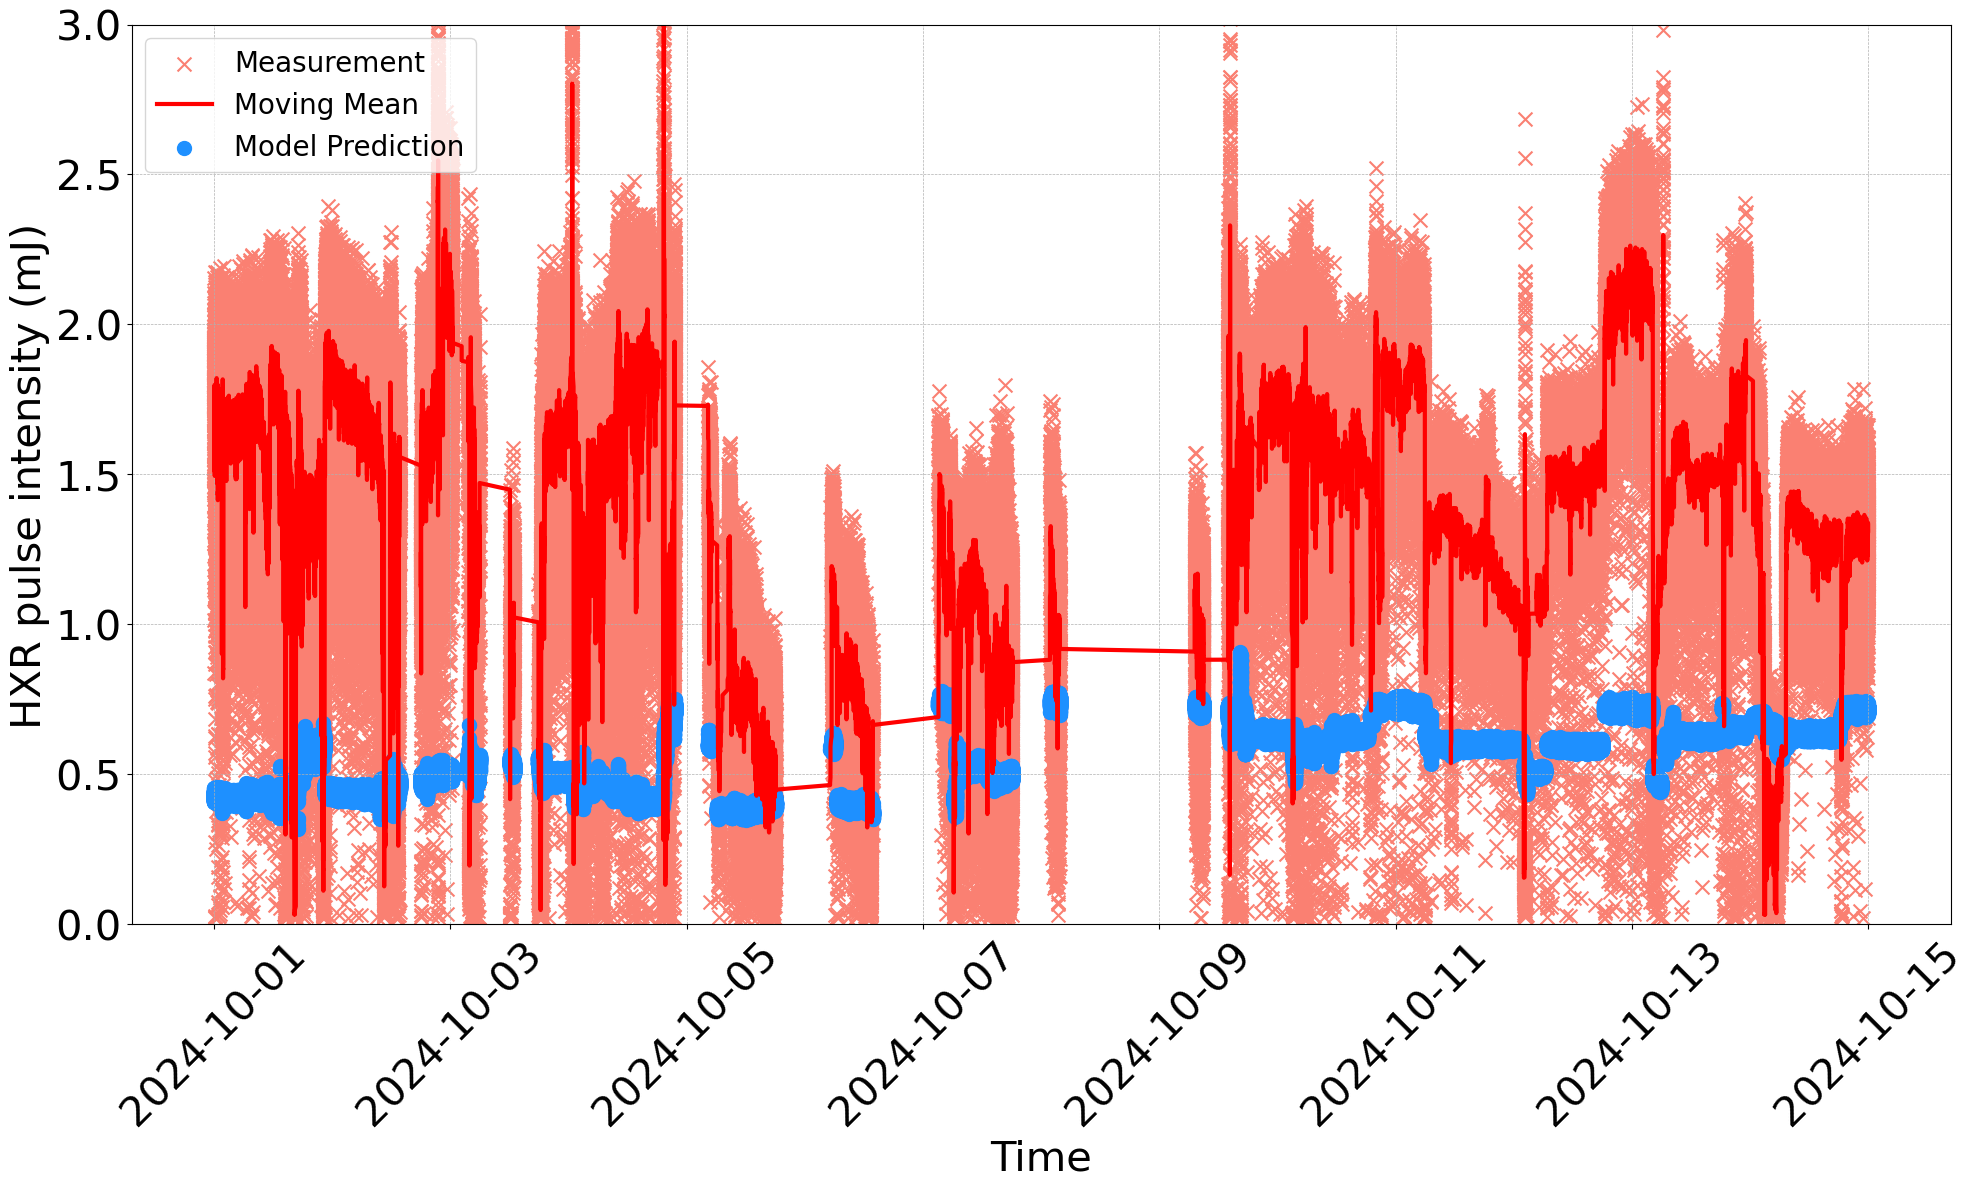

In [36]:
import matplotlib.dates as mdates

# Set the format of the x-axis labels
date_format = mdates.DateFormatter('%m-%d %H:%M')

fontsize = 30
plt.figure(figsize=(20,12))
window_size = 50

moving_avg = ground_truth.rolling(window=window_size).mean()
shot_axis = np.arange(selected_validation_set.shape[0])
plt.scatter(selected_validation_set.index, ground_truth, label='Measurement', color='salmon', marker='x',s=100)
plt.plot(selected_validation_set.index, moving_avg, label='Moving Mean', color='red', linewidth=3)
plt.scatter(selected_validation_set.index, model_output, label='Model Prediction', color='dodgerblue', marker='o', s=100)
plt.xlabel('Time', fontsize=fontsize)
plt.ylabel('HXR pulse intensity (mJ)',fontsize=fontsize)
# Set the format of the x-axis labels
# plt.gca().xaxis.set_major_formatter(date_format)
plt.ylim([0, 3])
plt.legend(fontsize=20, loc='upper left')
plt.tick_params(labelsize=fontsize)
plt.tick_params(axis='x', rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


### February 2025

In [37]:
# get testing samples from dataset
data_from_archiver = pd.read_pickle('/sdf/data/ad/ard/u/zihanzhu/ml/lcls_fel_tuning/dataset/hxr_archiver_Feb2025.pkl')
data_from_archiver = dataset_filter(data_from_archiver)

test_set = data_from_archiver
print('test set size:',test_set.shape[0])

test set size: 775903


In [38]:
# Define the fractions of the total number of rows for the selected validation set
selected_ranges = [(0, 1)]

selected_validation_set = pd.DataFrame()
for start_fraction, end_fraction in selected_ranges:
    start_index = int(start_fraction * len(test_set))
    end_index = int(end_fraction * len(test_set))
    subset = test_set.iloc[start_index:end_index]
    selected_validation_set = pd.concat([selected_validation_set, subset])


input_data = torch.tensor(selected_validation_set[lume_model.input_names].values)
model_output = lume_module(input_data)
ground_truth = selected_validation_set[lume_model.output_names]

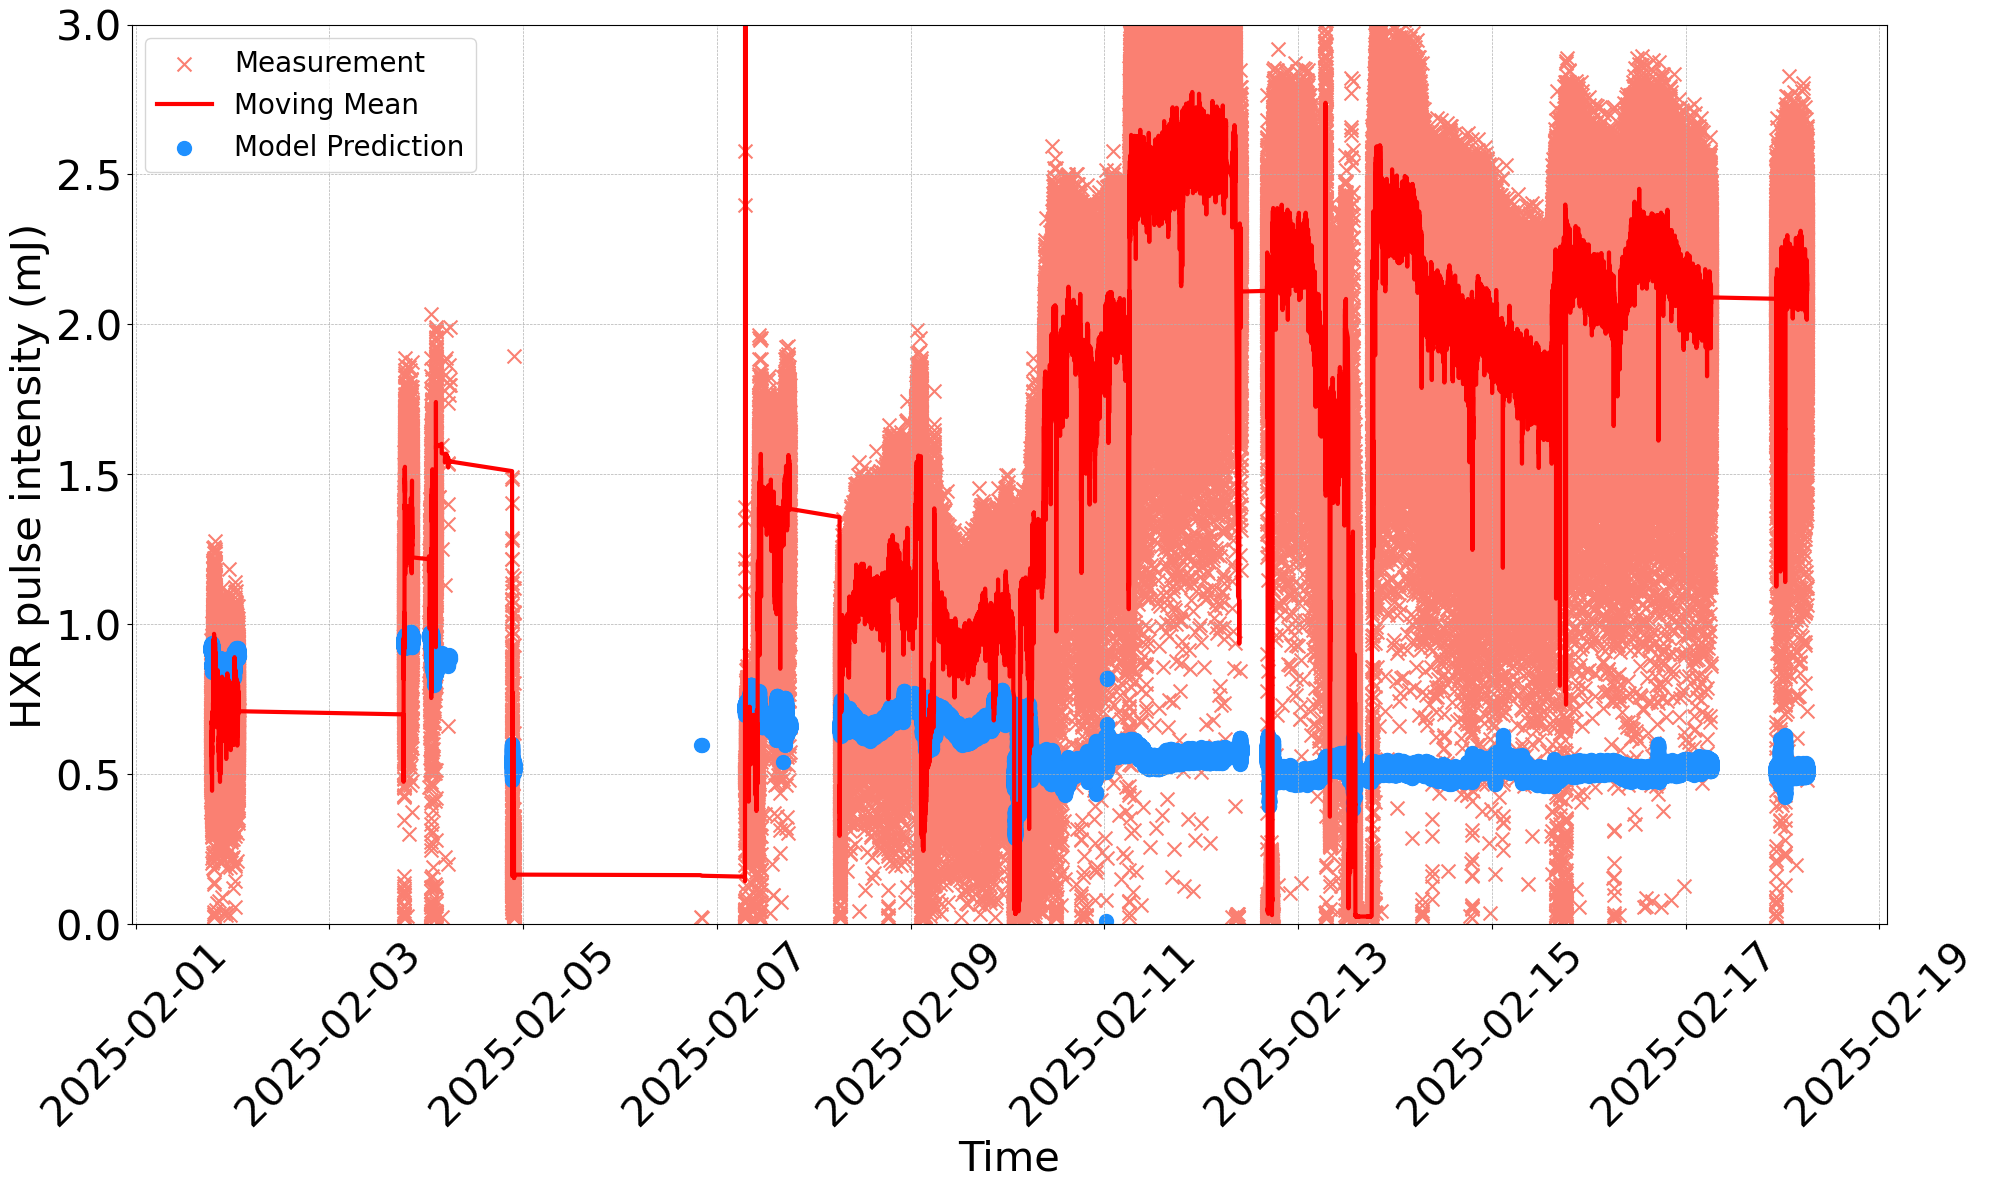

In [39]:
date_format = mdates.DateFormatter('%m-%d %H:%M')

fontsize = 30
plt.figure(figsize=(20,12))
window_size = 50

moving_avg = ground_truth.rolling(window=window_size).mean()
shot_axis = np.arange(selected_validation_set.shape[0])
plt.scatter(selected_validation_set.index, ground_truth, label='Measurement', color='salmon', marker='x',s=100)
plt.plot(selected_validation_set.index, moving_avg, label='Moving Mean', color='red', linewidth=3)
plt.scatter(selected_validation_set.index, model_output, label='Model Prediction', color='dodgerblue', marker='o', s=100)
plt.xlabel('Time', fontsize=fontsize)
plt.ylabel('HXR pulse intensity (mJ)',fontsize=fontsize)
# Set the format of the x-axis labels
# plt.gca().xaxis.set_major_formatter(date_format)
plt.ylim([0, 3])
plt.legend(fontsize=20, loc='upper left')
plt.tick_params(labelsize=fontsize)
plt.tick_params(axis='x', rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
